In [87]:
import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
from statistics import mode
from copy import deepcopy

In [2]:
datadir='../Datasets/'

### Problem 1
Find the top 5 ranked airports (with respect to the degree centrality) in the state of New York. Present results in the same form as Table 3.3.

In [10]:
## read edges and make graph
airports_df = pd.read_csv(datadir+'Airport/connections.csv')
tuples = [tuple(x) for x in airports_df.values]
ga = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ["weight"])

loc_df = pd.read_csv(datadir+'Airport/airports_loc.csv')
ny_airports = loc_df.loc[loc_df['state']=='NY']
ny_ap_names = ny_airports['airport'].tolist()

## subgraph induced by all airports from New York
ga_ny = ga.subgraph([v for v in ga.vs() if v['name'] in ny_ap_names])
ga_ny = ga_ny.simplify(multiple=False)

The following cell contains code from the Chapter 3 notebook on GitHub to produce Table 3.3 for NY 

In [11]:
## compute normalized weights 
mw = np.max(ga_ny.es['weight'])
ga_ny.es()['normalized_weight'] = [w/mw for w in ga_ny.es()['weight']]

## total degree centrality 
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

## compute same centrality measures for the NY subgraph as Table 3.3
df = pd.DataFrame({'airport':ga_ny.vs()['name'],\
                  'degree':degree_centrality(ga_ny,weights='normalized_weight'),\
                  'pagerank':ga_ny.pagerank(weights='weight'),'authority':ga_ny.authority_score(weights='weight'),\
                  'hub':ga_ny.hub_score(weights='weight'),'between':ga_ny.betweenness(),\
                  'closeness':ga_ny.closeness()})

## normalize betweenness
n = ga_ny.vcount()
df['between'] = [2*x/((n-1)*(n-2)) for x in df['between']]

## sort w.r.t. degree centrality, look at top airports
df = df.sort_values(by='degree', ascending=False)
df.head()

,airport,degree,pagerank,authority,hub,between,closeness
0,JFK,0.129844,0.327600,1.000000,0.373760,0.356250,0.705882
2,BUF,0.076222,0.187068,0.261299,1.000000,0.092361,0.705882
4,ROC,0.041181,0.104605,0.141841,0.546989,0.000000,0.631579
5,SYR,0.033720,0.092834,0.113975,0.459400,0.134028,0.750000
1,LGA,0.030008,0.103534,0.213367,0.078989,0.157639,0.750000


### Problem 2
Generate Chung-Lu graph $\mathcal{G}(\mathbf{w})$ on $n = 10\,000$ nodes and power-law degree distribution using the set of weights prescribed by (2.6) with $\gamma = 2.5$, $\delta = 1$ and $\Delta=\sqrt{n} = 100$. For each centrality measure (degree, pagerank, authority, hub, between, closeness) compute $f(k)$, the average centrality measure over all nodes of degree $k$. Plot $f(k)$ as a function of $k$. Is there any visible correlation between a given centrality measure and the degree of a node?

The following cell contains code for generating Chung-Lu graphs from the Chapter 2 Notebook

In [3]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [53]:
n = 10000
gamma = 2.5
delta = 1
Delta = 100

i = np.arange(1, n+1)
deg = delta * np.power(n/(i-1+n/(Delta/delta)**(gamma-1)), 1/(gamma-1))
m = int(np.mean(deg)*n/2)
tuples = fastCL(deg,m)
G = ig.Graph.TupleList(tuples)
k = G.degree()

df = pd.DataFrame({'k':k,'degree':degree_centrality(G),'pagerank':G.pagerank(),'authority':G.authority_score(),\
                  'hub':G.hub_score(),'between':G.betweenness(),'closeness':G.closeness()})

## normalize betweenness
n = G.vcount()
df['between'] = [2*x/((n-1)*(n-2)) for x in df['between']]

df.head()

,k,degree,pagerank,authority,hub,between,closeness
0,5,0.000616,0.000163,0.012506,0.012506,0.000519,0.198447
1,3,0.000370,0.000106,0.002436,0.002436,0.000137,0.178711
2,3,0.000370,0.000126,0.002571,0.002571,0.000286,0.177434
3,1,0.000123,0.000054,0.000192,0.000192,0.000000,0.150698
4,5,0.000616,0.000184,0.003998,0.003998,0.000598,0.181102


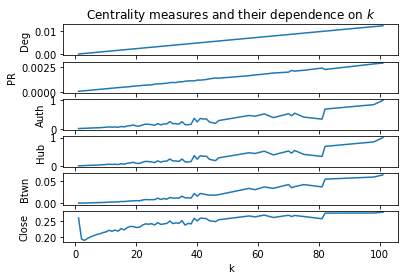

In [54]:
k_unique = np.unique(k)

centrality_measures = np.zeros([len(k_unique), 6])

for i in range(len(k_unique)):
    df1 = df.loc[df['k'] == k_unique[i]]
    averages = df1.mean(axis=0).to_numpy()
    centrality_measures[i] = averages[1:]
    
fig, axs = plt.subplots(6, 1)
    
axs[0].set_title("Centrality measures and their dependence on $k$")
axs[0].plot(k_unique, centrality_measures[:,0])
axs[0].set_ylabel("Deg")
axs[1].plot(k_unique, centrality_measures[:,1])
axs[1].set_ylabel("PR")
axs[2].plot(k_unique, centrality_measures[:,2])
axs[2].set_ylabel("Auth")
axs[3].plot(k_unique, centrality_measures[:,3])
axs[3].set_ylabel("Hub")
axs[4].plot(k_unique, centrality_measures[:,4])
axs[4].set_ylabel("Btwn")
axs[5].plot(k_unique, centrality_measures[:,5])
axs[5].set_ylabel("Close")
axs[5].set_xlabel("k")
plt.show()

$f(k)$ appears to be positively correlated with $k$.

### Problem 3
The original airport dataset is not strongly connected but it is almost weakly connected. There are two weak components: the giant one consisting of all but two airports, and the small one with two airports that only link to each other. Remove the two nodes to make the graph weakly connected. For each centrality measure (degree, pagerank, authority, hub, between, closeness) perform the following experiment: sort all nodes with respect to a given centrality measure. How many nodes with the largest score do we need to remove so that the graph is no longer weakly connected? Compare this with the number of nodes with the smallest score that need to be removed. 

In [114]:
## read edges and make graph
airports_df = pd.read_csv(datadir+'Airport/connections.csv')
tuples = [tuple(x) for x in airports_df.values]
ga = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ["weight"])

## remove the two airports that link only to each other
ga = ga.subgraph([v for v in ga.vs() if len(ga.neighbors(v, mode='all'))>1])

## compute normalized weights 
mw = np.max(ga.es['weight'])
ga.es()['normalized_weight'] = [w/mw for w in ga.es()['weight']]

df = pd.DataFrame({'airport':ga.vs()['name'],\
                  'degree':degree_centrality(ga,weights='normalized_weight'),\
                  'pagerank':ga.pagerank(weights='weight'),'authority':ga.authority_score(weights='weight'),\
                  'hub':ga.hub_score(weights='weight'),'between':ga.betweenness(),\
                  'closeness':ga.closeness()})

## normalize betweenness
n = ga.vcount()
df['between'] = [2*x/((n-1)*(n-2)) for x in df['between']]

## function which implements node deletion and checks for connectivity of graph
def disconnect_graph(G, node_list, centrality_measure, high_to_low=True):
    
    G_copy = deepcopy(G)
    
    delete_list = []
    while G_copy.is_connected(mode='weak'):
        
        G_copy = deepcopy(G)
        
        if high_to_low:
            delete_list.append(node_list.pop(0))
        else:
            delete_list.append(node_list.pop(-1))
           
        G_copy.delete_vertices(delete_list)
        
    if high_to_low:
        print("Removing {0} nodes with the highest {1} centrality scores produces a disconnected graph.".format(len(delete_list), centrality_measure))
    else:
        print("Removing {0} nodes with the lowest {1} centrality scores produces a disconnected graph.".format(len(delete_list), centrality_measure))
    
centralities = ['degree', 'pagerank', 'authority', 'hub', 'between', 'closeness']

for c in centralities:

    ## sort w.r.t. degree centrality, look at top airports
    df = df.sort_values(by=c, ascending=False)
    node_list = df.index.tolist()
    disconnect_graph(ga, deepcopy(node_list), c, True)
    disconnect_graph(ga, deepcopy(node_list), c, False)


Removing 2 nodes with the highest degree centrality scores produces a disconnected graph.
Removing 149 nodes with the lowest degree centrality scores produces a disconnected graph.
Removing 2 nodes with the highest pagerank centrality scores produces a disconnected graph.
Removing 162 nodes with the lowest pagerank centrality scores produces a disconnected graph.
Removing 2 nodes with the highest authority centrality scores produces a disconnected graph.
Removing 6 nodes with the lowest authority centrality scores produces a disconnected graph.
Removing 2 nodes with the highest hub centrality scores produces a disconnected graph.
Removing 432 nodes with the lowest hub centrality scores produces a disconnected graph.
Removing 5 nodes with the highest between centrality scores produces a disconnected graph.
Removing 432 nodes with the lowest between centrality scores produces a disconnected graph.
Removing 1 nodes with the highest closeness centrality scores produces a disconnected graph

### Problem 5
From the airport graph, generate a state-to-state graph by collapsing every node in a state to a single node, adding the edge weights and removing loops. Let $G$ be this new graph. 

In [147]:
loc_df = pd.read_csv(datadir+'Airport/airports_loc.csv')
state_list = np.unique(loc_df["state"].to_numpy())

In [148]:
for i in range(len(state_list)):
    local_airports = loc_df.loc[loc_df['state']==state_list[i]]
    local_names = local_airports['airport'].tolist()
    
    for v in ga.vs():
        if v['name'] in local_names:
            v['state_name'] = state_list[i]
            v['state_id'] = i

mapping = ga.vs['state_id']
ga.vs['name'] = ga.vs['state_name']

ga.contract_vertices(mapping, combine_attrs='first')

ga = ga.simplify(multiple=True, loops=True, combine_edges=sum)

1. Is $G$ weakly connected? Strongly connected?


In [149]:
print("Is G weakly connected? ", ga.is_connected(mode='weak'))
print("Is G strongly connected? ", ga.is_connected(mode='strong'))

Is G weakly connected?  True
Is G strongly connected?  True


2. Which state has the most incoming passengers? The most departing passengers?


In [150]:
deg_in = np.array(ga.strength(mode='in', weights="weight"))
max_in = np.argmax(deg_in)
print("State with the most incoming passengers: ", ga.vs['name'][max_in])
deg_out = np.array(ga.strength(mode='out', weights="weight"))
max_out = np.argmax(deg_out)
print("State with the most departing passengers: ", ga.vs['name'][max_out])

State with the most incoming passengers:  CA
State with the most departing passengers:  CA


3. Which pair of two states, $x$ and $y$, have the most passengers travelling from $x$ to $y$?


In [151]:
max_weight = 0
state1 = None
state2 = None
for v in ga.vs():
    neighbourlist = ga.neighbors(v)
    for u in neighbourlist:
        weight = ga.es[ga.get_eid(v, ga.vs[u], directed=True)]['weight']
        if weight > max_weight:
            max_weight = weight
            state1 = v['name']
            state2 = ga.vs[u]['name']
print("{0} and {1} have the most passengers traveling from {0} to {1}".format(state1, state2))

FL and GA have the most passengers traveling from FL to GA


4. Recreate Table 3.3 for graph $G$. Which states have the highest degree centrality? Betweenness centrality?

In [137]:
## compute normalized weights 
mw = np.max(ga.es['weight'])
ga.es()['normalized_weight'] = [w/mw for w in ga.es()['weight']]

## compute same centrality measures for the NY subgraph as Table 3.3
df = pd.DataFrame({'airport':ga.vs()['name'],\
                  'degree':degree_centrality(ga,weights='normalized_weight'),\
                  'pagerank':ga.pagerank(weights='weight'),'authority':ga.authority_score(weights='weight'),\
                  'hub':ga.hub_score(weights='weight'),'between':ga.betweenness(),\
                  'closeness':ga.closeness()})

## normalize betweenness
n = ga.vcount()
df['between'] = [2*x/((n-1)*(n-2)) for x in df['between']]

## sort w.r.t. degree centrality, look at top airports
df = df.sort_values(by='degree', ascending=False)
df.head()

,airport,degree,pagerank,authority,hub,between,closeness
4,CA,0.135169,0.075945,0.969776,0.971339,0.021798,0.943396
9,FL,0.131269,0.073844,1.000000,1.000000,0.025406,0.943396
43,TX,0.130073,0.077688,0.925013,0.925351,0.028128,0.980392
10,GA,0.107684,0.064350,0.829181,0.827263,0.024257,0.961538
14,IL,0.104197,0.063423,0.743699,0.742924,0.037450,1.000000


In [138]:
## sort w.r.t. betweennes centrality, look at top airports
df = df.sort_values(by='between', ascending=False)
df.head()

,airport,degree,pagerank,authority,hub,between,closeness
14,IL,0.104197,0.063423,0.743699,0.742924,0.037450,1.000000
35,OH,0.047637,0.030171,0.362872,0.363208,0.030658,0.980392
43,TX,0.130073,0.077688,0.925013,0.925351,0.028128,0.980392
23,MN,0.042512,0.031069,0.284189,0.284231,0.026444,0.961538
7,DC,0.048661,0.030077,0.418860,0.418279,0.026230,0.980392


California has the highest degree centrality. Illinois has the highest betweenness centrality. 